In [ ]:
from IPython.core.display import Image, display

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

In [ ]:
def load_spam():
  data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data',header=None)
  data.columns=["wf_make",
"wf_address",
"wf_all",
"wf_3d",
"wf_our",
"wf_over",
"wf_remove",
"wf_internet",
"wf_order",
"wf_mail",
"wf_receive",
"wf_will",
"wf_people",
"wf_report",
"wf_addresses",
"wf_free",
"wf_business",
"wf_email",
"wf_you",
"wf_credit",
"wf_your",
"wf_font",
"wf_000",
"wf_money",
"wf_hp",
"wf_hpl",
"wf_george",
"wf_650",
"wf_lab",
"wf_labs",
"wf_telnet",
"wf_857",
"wf_data",
"wf_415",
"wf_85",
"wf_technology",
"wf_1999",
"wf_parts",
"wf_pm",
"wf_direct",
"wf_cs",
"wf_meeting",
"wf_original",
"wf_project",
"wf_re",
"wf_edu",
"wf_table",
"wf_conference",
"cf_;",
"cf_(",
"cf_[",
"cf_!",
"cf_$",
"cf_#",
"cap_average",
"cap_longest",
"cap_total",
"target"]
  return data

# Problema de clasificación para esta sesión: spam detection

## Repositorio de bases de datos de UCI
Es uno de los problemas clásicos del [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php). En general la manera de comparar las prestaciones de algoritmos de aprendizaje es evaluar su capacidad para construir modelos en problemas *benchmark*. Existe otra aproximación, el campo de *Statistical Learning Theory* (SLT), que trata de analizar estos comportamientos mediante cotas en la capacidad de generalización de estos algoritmos, al estilo de las cotas de Shannon en Teoría de la Información. A efectos prácticos, si bien la aproximación SLT parece más robusta, la experiencia real es que las estimaciones de prestaciones basadas en *benchmarks* se parecen más a lo que experimentan los usuarios de estos algoritmos al ponerlos en práctica con datos reales.

El repositorio de bases de datos de UCI es uno de los más empleados en el diseño de algoritmos de propósito general y en los programas de formación de científicos de datos, ya que abarca problemas supervisados y no supervisados de muy diversa índole y permite adquirir intuiciones acerca del funcionamiento de estos algoritmos en situaciones diversas.



## Spam detection database
- 4601 observaciones (1813 spam, 394%)
- target binario: spam ($y=1$) o no spam ($y=0$)
- No disponemos de los textos, las observaciones están formadas por 57 variables continuas
  - 48 variables reales continuas en el intervalo [0,100] *word_freq_WORD*: frecuencia de aparición de la palabra *WORD* en el correo (en porcentaje)
  - 6 variables reales continuas en el intervalo [0,100] *char_freq_CHAR*: frecuencia de aparición del caracter *CHAR* en el correo (porcentaje)
  - 1 variable real continua: longitud promedio de secuencias de caracteres en mayúscula ininterrumpidos
  - 1 variable entera continua: longitud de la secuencia de mayúsculas ininterrumpida más larga
  - 1 variable entera continua: número total de mayúsculas en el correo
  

### Consideraciones sobre la base de datos
- La base es de junio-julio de 1999
  - El NLP no estaba tan desarrollado como ahora,
    - Los correos electrónicos eran básicamente texto ASCII
    - así que buscan estadísticos sobre repeticiones de palabras
- El dueño de la base de datos se llama George
- Trabajan en Hewlett Packard
  - Pueden buscar códigos de área y palabras clave dentro de la organización y de los contactos y/o proyectos de George

## Proceso de carga de datos
Pasos que tenemos que dar hasta poder emplear el algoritmo de entrenamiento
1. Leer los datos
2. Separar observaciones de *targets*
3. Dividir entre conjunto de entrenamiento y conjunto de test

### 1. Lectura de los datos
- Importar los datos desde disco.
- En este caso es un csv, con lo que lo cargaremos en **pandas** para poder ver alguna descripción de las observaciones


In [ ]:
data = load_spam()
print("Cargadas {0:d} observaciones con {1:d} columnas\n".format(len(data), len(data.columns)))
print("Ejemplos")
data.head()

Cargadas 4601 observaciones con 58 columnas

Ejemplos


,wf_make,wf_address,wf_all,wf_3d,wf_our,wf_over,wf_remove,wf_internet,wf_order,wf_mail,...,cf_;,cf_(,cf_[,cf_!,cf_$,cf_#,cap_average,cap_longest,cap_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [ ]:
data.describe()

,wf_make,wf_address,wf_all,wf_3d,wf_our,wf_over,wf_remove,wf_internet,wf_order,wf_mail,...,cf_;,cf_(,cf_[,cf_!,cf_$,cf_#,cap_average,cap_longest,cap_total,target
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


### 2. Separar observaciones de *targets*
Leyendo la documentación de la base de datos vemos que el *target* es la última columna de cada registro de la tabla.

In [ ]:
X = data[data.columns[:57]].values
Y = data['target'].values
print("{0:d} observaciones con {1:d} columnas".format(X.shape[0], X.shape[1]))
print("{0:d} targets".format(len(Y)))
print("Valores de los targets:")
print(np.unique(Y))

4601 observaciones con 57 columnas
4601 targets
Valores de los targets:
[0 1]


### 3. Dividir entre conjunto de entrenamiento y conjunto de test
El éxito de un modelo de aprendizaje automático se mide en su capacidad de generalización procesando datos que no fueron empleados durante el entrenamiento. Para ello necesitamos disponer de dos conjuntos disjuntos de datos:
- el **conjunto de entrenamiento**, que son las observaciones que se le pasan al **algoritmo de entrenamiento** (al método `fit`) para que éste optimice el modelo
- el **conjunto de test**, es un conjunto separado que se procesa con el **modelo  ya entrenado** y que usamos para medir la **capacidad de generalización** (con el método `score`)). Un modelo generaliza bien cuando las prestaciones que se obtienen en el conjunto de test no son muy diferentes de las que se obtienen en el conjunto de entrenamiento.




En cualquier caso no conviene perder de vista que:
- **el conjunto de test sólo es un conjunto más**, es decir, que cuando eventualmente pongamos el modelo **en producción** vamos a tener que seguir monitorizando la generalización con los conjuntos de datos de test que estemos recibiendo (cada día, cada hora, cada semana, etc)
- A veces cuando refinamos un modelo **tomamos decisiones de diseño en función de las prestaciones que se alcanzan en el conjunto de test**. Esta práctica demasiado habitual introduce sesgos en la estimación de las prestaciones reales del modelo porque estamos **realimentando información del test** al entrenamiento del modelo. De algún modo es como si el test estuviese participando del entrenamiento, luego no se puede asegurar 100% que el conjunto de test sea independiente.


En algunas bases de datos esta división viene hecha o sale de un modo natural, por ejemplo si las observaciones siguen un orden temporal (entrenar con datos obtenidos hasta una fecha y hacer el test con los datos obtenidos a partir de esa fecha).

Para las situaciones en las que la división no viene hecha lo más habitual suele ser dejar más datos para entrenar que para testear, ya que el modelo que vaya a producción se va a entrenar con todos los datos disponibles:
- 50% entrenamiento, 50% test
- 70% entrenamiento, 30% test
- 80% entrenamiento, 20% test


Existen maneras más fiables de estimar la capacidad de generalización que el empleo de un único conjunto de test. La más utilizada en la práctica es **validación cruzada**, que revisaremos en la próxima sesión.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, # observaciones
                                                    Y, # targets alineados con las observaciones
                                                    test_size=0.3, # ratio de observaciones que se van al conjunto de test,
                                                    random_state=42) # estado del generador de números aleatorios

## Entrenamiento y validación del modelo
Vamos a emplear la implementación de [*Arboles*](https://scikit-learn.org/stable/modules/tree.html) contenida en el módulo [**sklearn**](https://scikit-learn.org/stable/index.html) de python. El módulo sklearn contiene implementaciones de una gran variedad de algoritmos de aprendizaje automático, y la manera de consumirlas es la misma.
Todas las implementaciones tienen tres métodos fundamentales:
- `fit`: Entrenamiento del modelo. En los algoritmos de aprendizaje supervisado los argumentos son un array de numpy con las observaciones, una observación en cada **fila** y un array con los targets
- `predict`: Explotar el modelo. El argumento es un numpy array con las observaciones del conjunto de test. La salida es el target estimado para cada fila del argumento de entrada
- `score`: Evaluar el modelo. Cada modelo tiene una función de *score* particular, que es el estadístico que se calcula sobre las  predicciones hechas para el conjunto de test y nos cuantifica la calidad de estas predicciones. En un problema de clasificación se emplea la **tasa de aciertos**, es decir la fracción de las observaciones de test para las que el modelo ha encontrado la predicción correcta. Los argumentos para invocar el método `score` son las observaciones de test y los target verdaderos de test, a fin de poder medir estadístico sobre las predicciones hechas por el modelo y estos *targets* reales.


### Primera valoración de los resultados
En primer lugar tenemos que comparar los resultados con un *bechmark* trivial. Sería un valor que conseguiríamos sin ningún esfuerzo (sin entrenar). En este caso hay un clasificador que nos garantiza un acierto de en torno al 60%: decir que todos los correos son **no spam**

In [ ]:
baseline = max((1-np.mean(y_test)), np.mean(y_test))
baseline_spam = baseline

# Árboles de Decisión
Construyen una estructura jerárquica mediante la aplicación **recursiva** de clasificadores de tipo *stump*

## Clasificador *stump*
- Definido mediante una variable y un umbral.
- Divide el espacio de entrada en dos, aquellos patrones para los que el test es verdadero y aquellos patrones para los que el test es falso.



## Construcción del árbol
1. Se comienza con un **nodo raíz**, que es un nodo que contiene a todas las observaciones del conjunto de entrenamiento
2.  Se determina un test de umbral para el nodo raíz que divide este nodo de dos **nodos rama**
3.  **Recursión** aplicada a cada nodo rama
    1. Si el nodo rama es **suficientemente homogéneo** se declara **nodo hoja**
        - se le asigna una clase de salida para etiquetar observaciones
        - y se saca de la lista de nodos rama
    2. Si no es suficientemente homogéneo se subdivide a su vez en dos nodos rama; el nodo que se acaba de subdividir se saca de la lista de nodos hoja

## Evaluación del árbol
1. Cada observación de test se evalúa con el test de umbral del nodo raíz e ingresa en una de las ramas del árbol
2. Recursivamente va descendiendo a través de los test de umbral de los nodos rama que le toque recorrer
3. Se asigna la clase target del nodo hoja en el que termine su recorrido por la jerarquía del árbol

## Implementación en sklearn

La clase `sklearn.tree.DecisionTreeClassifier` tiene los siguientes parámetros:
- `criterion`: "gini" o "entropy"
- `splitter`: "best" o "random"
- `max_depth`: máxima profundidad
- `min_samples_split`: mínimo número de observaciones para dividir el nodo
- `min_samples_leaf`: mínimo número de observaciones para que un nodo pueda ser hoja
- `min_weight_fraction_leaf`: para cuando tenemos un peso para cada observación, mismo concepto que min_samples_leaf
- `max_features`: máximo número de variables en el bucle para buscar el mejor test de umbral
- `max_leaf_nodes`: número máximo de hojas en *best-first*
- `min_impurity_decrease`: un nodo se divide si consigue que la impureza decaiga al menos esta cantidad
- `min_impurity_split`: un nodo se divide sólo si su impureza pasa este valor. Si no lo pasa se queda en hoja
- `class_weight`: peso de los errores de cada clase

## Spam detection con árboles de decisión

In [ ]:
data = load_spam()
X = data[data.columns[:57]].values
Y = data['target'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
baseline = max(100.*(1-np.mean(y_test)), 100.*np.mean(y_test))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(max_leaf_nodes=6)
DT.fit(x_train, y_train)
acierto_entrenamiento = DT.score(x_train, y_train)
acierto_test = DT.score(x_test, y_test)
print("Acierto en el conjunto de entrenamiento: {0:.2f}%".format(acierto_entrenamiento*100.))
print("Acierto en el conjunto de test: {0:.2f}%".format(acierto_test*100.))

Acierto en el conjunto de entrenamiento: 90.22%
Acierto en el conjunto de test: 88.49%


Los árboles de decisión (si no tienen muchos nodos) se pueden visualizar

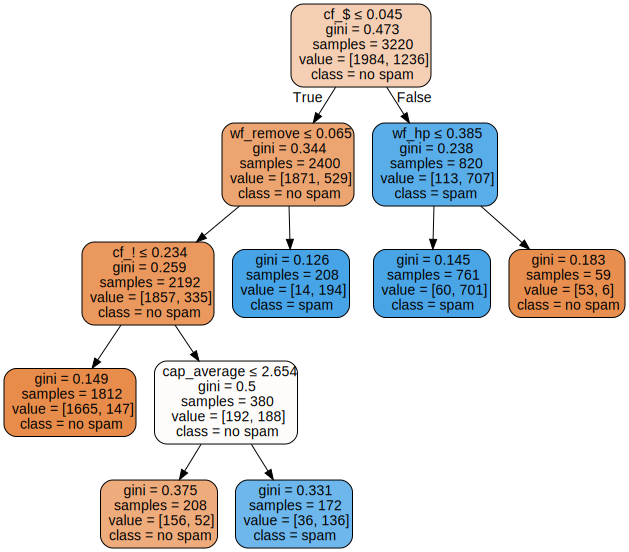

In [ ]:
import graphviz
from sklearn import tree
dot_Data = tree.export_graphviz(DT,
                                out_file=None,
                                feature_names = data.columns[:-1],
                               class_names=['no spam','spam'],
                                filled=True,
                                rounded=True,
                              special_characters=True)
graph = graphviz.Source(dot_Data)
graph

### Influencia del número de hojas

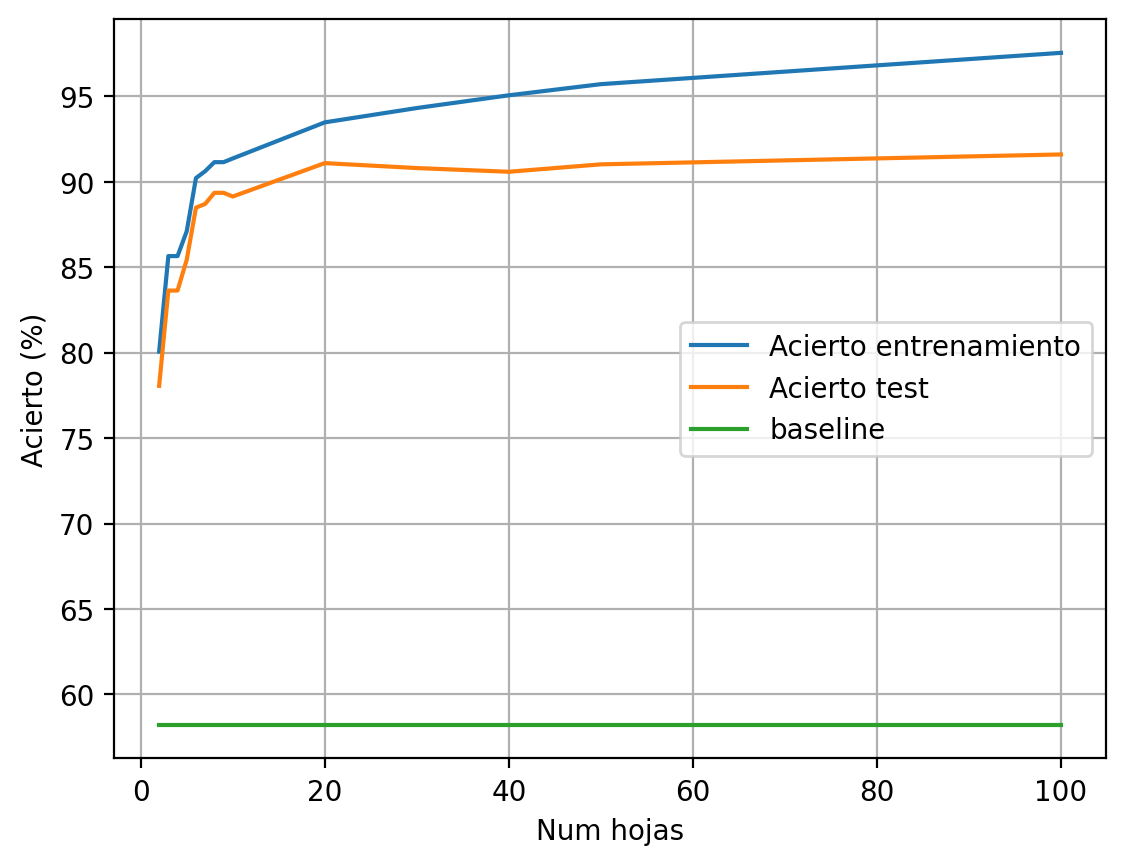

El número de hojas que da el mejor resultado en test es 100, acierto del  91.60


In [ ]:
##
##
##
##
##
##
v_num_hojas = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]

dt_entr = np.empty(len(v_num_hojas))
dt_test = np.empty(len(v_num_hojas))
for ih,hh in enumerate(v_num_hojas):
    DT = DecisionTreeClassifier(max_leaf_nodes=hh)
    DT.fit(x_train, y_train)
    dt_entr[ih] = 100.*DT.score(x_train, y_train)
    dt_test[ih] = 100.*DT.score(x_test, y_test)
plt.figure()
plt.plot(v_num_hojas, dt_entr, label='Acierto entrenamiento')
plt.plot(v_num_hojas, dt_test, label='Acierto test')
plt.plot(v_num_hojas, baseline*np.ones(len(v_num_hojas)), label='baseline')
_ = plt.xlabel('Num hojas')
_ = plt.ylabel('Acierto (%)')
_ = plt.legend()
plt.grid()
best_k = v_num_hojas[np.argmax(dt_test)]
plt.show()
print("El número de hojas que da el mejor resultado en test es {0:d}, acierto del  {1:.2f}".format(best_k,
                                                                                                     np.max(dt_test)))
acierto_spam_dt = np.max(dt_test)

# Parámetros entrenables e hiperparámetros

Dentro del entrenamiento árbol de decisión hay que asignar valores a dos tipos de parámetros:
- Parámetros entrenables: Variable y umbral en cada split. Se ajustan durante la optimización que se produce al invocar el método `fit`
- Hiperparámetros: se ajustan durante la creación del árbol (llamada al método `__init__` que se hace al ejecutar `DecisionTreeClassifier()`.  Condicionan la optimización del método fit. Usamos información a priori para ajustarlos, es la manera que tenemos de controlar la **capacidad de generalización del árbol**.

# Sobreajuste

Cada modelo de aprendizaje automático lleva implícita una **capacidad expresiva**: potencialidad de ajustar los valores de sus parámetros o su arquitectura para capturar patrones en los datos. En general, cuantos más parámetros (o más compleja sea la estructura), mayor capacidad expresiva.

En el árbol de decisión el número de nodos marca la capacidad expresiva.

La esencia del entrenamiento del modelo consiste en capturar patrones existentes en los datos debidos a la tarea que queremos resolver. Una manera trivial de resolver el problema de spam para el conjunto de entrenamiento es construir un árbol donde cada observación acabe en una hoja independiente. El acierto de este modelo superexpresivo en el conjunto de entrenamiento será del 100%. Pero no conseguimos un acierto del 100% en el conjunto de test: estamos **sobreajustando** (*overfitting*) los parámetros del modelo al conjunto de entrenamiento.



Si una hoja del árbol contiene una única observación, esa observación no ha llegado a esa hoja por ser spam o no spam, ha llegado ahí por ser diferente a todas las demás observaciones. Por lo tanto esa rama no está capturando un patrón que nos ayude a separar spam de no spam, sino a separar correos idénticos a la observación que define la hoja de cualquier otro correo, independientemente de su clase *target*.

Limitando el número de hojas podemos controlar el sobreajuste pero corremos el riesgo de **limitar la capacidad expresiva** impidiendo que el modelo pueda capturar todos los patrones relevantes.

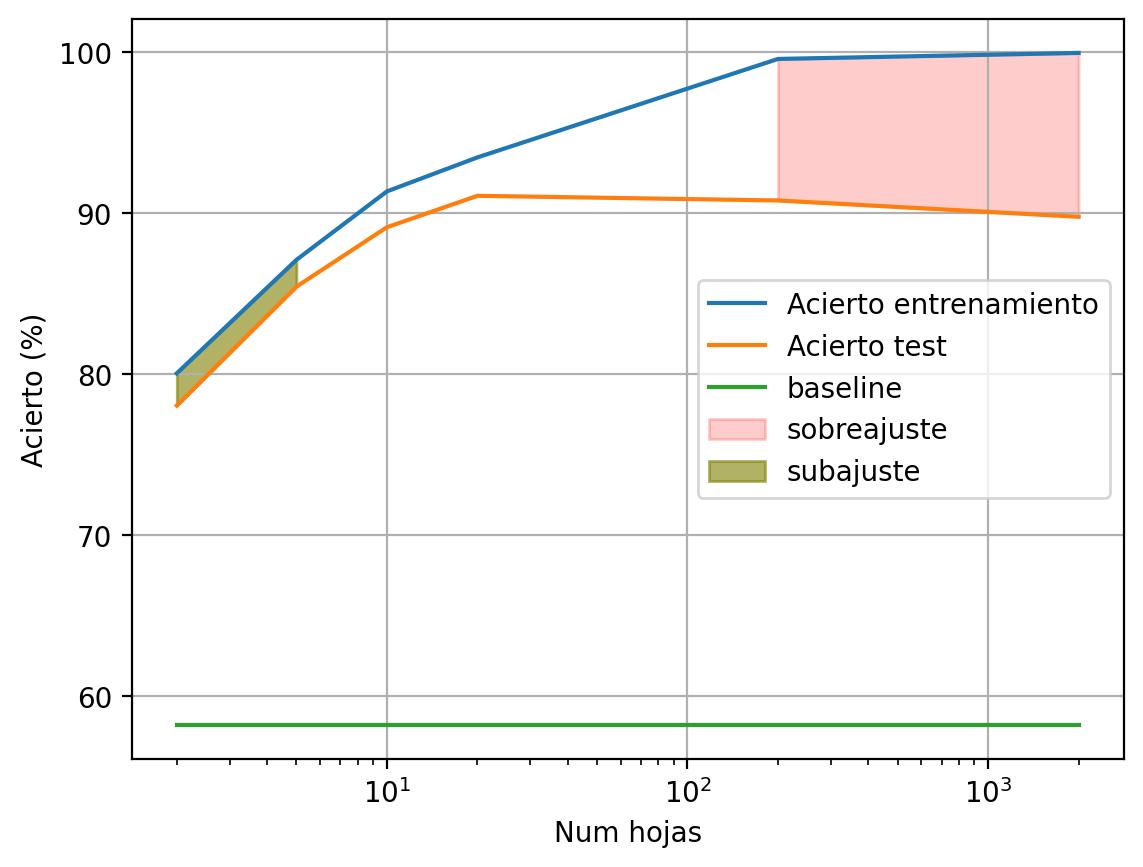

In [ ]:
v_num_hojas = [2,5,10, 20, 200, 2000]

dt_entr = np.empty(len(v_num_hojas))
dt_test = np.empty(len(v_num_hojas))
for ih,hh in enumerate(v_num_hojas):
    DT = DecisionTreeClassifier(max_leaf_nodes=hh)
    DT.fit(x_train, y_train)
    dt_entr[ih] = 100.*DT.score(x_train, y_train)
    dt_test[ih] = 100.*DT.score(x_test, y_test)
plt.figure()
plt.plot(v_num_hojas, dt_entr, label='Acierto entrenamiento')
plt.plot(v_num_hojas, dt_test, label='Acierto test')
plt.plot(v_num_hojas, baseline*np.ones(len(v_num_hojas)), label='baseline')
plt.xscale('log')
plt.fill_between(np.array([200,2000]),
                dt_entr[-2:],
                dt_test[-2:],
                color='red',
                alpha=0.2,
                label='sobreajuste')
plt.fill_between(np.array([2,5]),
                dt_entr[:2],
                dt_test[:2],
                color='olive',
                alpha=0.6,
                label='subajuste')
_ = plt.xlabel('Num hojas')
_ = plt.ylabel('Acierto (%)')
_ = plt.legend()
plt.grid()


## Ejercicio
Estudiar la influencia de alguno de los **hiperparámetros** de los que depende la configuración del árbol de decisión. Reemplazando `max_leaf_nodes` por otro parámetro intentar conseguir árboles parecidos.

In [ ]:
#Respuesta

## Ventajas y limitaciones de árboles
- :o) Resuelven de modo natural problemas de regresión, clasificación binaria y multiclase
- :o) Los splits binarios (aún en problemas multiclase, o con variables categóricas) ayudan a controlar el compromiso entre generalización y capacidad expresiva
- :o) Son fáciles de explicar (que no de interpretar, salvo que haya pocos nodos)
- :o) Son fáciles y relativamente poco costosos de evaluar
- :o( Fronteras de clasificación que no sean paralelas a los ejes son costosas de recrear
- :o( La optimización es de tipo *greedy*, los nodos rama más pegados a la raíz son determinantes en la solución global
- :o( Compromiso entre número de observaciones y número de variables. A medida que se avanza en la jerarquía cada vez hay menos observaciones para entrenar los nodos hoja. Si el número de variables es alto, podemos incurrir en sobreajustes (que el árbol separe observaciones individuales, no detecte patrones relacionados con la tarea a resolver)


# Random Forests

## Modelos basados en conjuntos (*ensemble methods*)
Hay una manera de robustecer modelos de aprendizaje automático que consiste en entrenar un conjunto de modelos con el mismo conjunto de entrenamiento de partida pero introduciendo elementos que introduzcan diversidad:
- submuestreando el conjunto de entrenamiento
- inicializando aleatoriamente alguno de los parámetros de diseño de cada miembro del conjunto.  

La manera de explotar el conjunto para hacer predicciones es que cada miembro hace su predicción para cada observación del conjunto de test y todas estas predicciones se combinan en una predicción global.
- Tomando la media de las predicciones
- Tomando la moda de las predicciones
- Ponderando los votos por la fiabilidad de cada miembro, etc.

De esta manera se consigue limitar la capacidad de sobreajuste o diluirla.

## Random Forest para clasificación o regresión
Es un algoritmo para generar $B$ árboles de decisión que se integran en un modelo de conjuntos orientado a resolver un problema de clasificación o regresión (recordad el algoritmo para generar cada árbol es el mismo sólo cambia la función de mediocridad y la manera de calcular el *target* que se asigna a cada nodo hijo.

El algoritmo es un bucle que se repite $B$ veces, una por cada árbol del bosque. Como entrada se reciben $N$ observaciones en $d$ dimensiones, con sus correspondientes *targets*, y un **tamaño de bosque** $B$.

1. Elegir al azar un subconjunto de observaciones del conjunto de entrenamiento de tamaño $N_b$
2. Aprender el árbol $T_b$ usando como conjunto de entrenamiento las $N_b$ observaciones pero introduciendo la siguiente modificación en el algoritmo del árbol:
   - Antes de aprender cada *stump* elegir al azar $m_b$ variables de las $d$ disponibles, es decir, cada nodo sólo ve un subconjunto de las variables de entrada para optimizar su test de umbral
3. Para hacer una predicción. Cada observación del conjunto de test se predice con los $B$ árboles. La predicción final del bosque es
    - en bosques de regresión: la media de las $B$ predicciones
    - en bosques de clasificación: la clase más votada


## Random Forest en sklearn para clasificación

El módulo que implementa *Random Forest* para clasificación es `sklearn.ensemble.RandomForestClassifier`. La API tiene hiperparámetros para controlar la capacidad de generalización de cada árbol y la del bosque en sí. Algunos de estos hiperparámetros son:
- `n_estimators`: Tamaño del bosque
- `bootstrap`: si usar o no todas las observaciones con cada árbol
- `oob_score`: medida de relevancia de cada variable
- `max_samples`: si hay bootstrap, número de observaciones para entrenar cada árbol

## Random Forest y spam detection

In [ ]:
data = load_spam()
X = data[data.columns[:57]].values
Y = data['target'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
baseline = max(100.*(1-np.mean(y_test)), 100.*np.mean(y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_leaf_nodes=6,
                           n_estimators=100)
RF.fit(x_train, y_train)
acierto_entrenamiento = RF.score(x_train, y_train)
acierto_test = RF.score(x_test, y_test)
print("Acierto en el conjunto de entrenamiento: {0:.2f}%".format(acierto_entrenamiento*100.))
print("Acierto en el conjunto de test: {0:.2f}%".format(acierto_test*100.))

Acierto en el conjunto de entrenamiento: 91.24%
Acierto en el conjunto de test: 91.31%


### Influencia del tamaño del bosque y de la complejidad de cada árbol

In [ ]:

v_hojas = [2,3,4,5,10,20,50,100]
v_arboles = [5,10,20,50,100,200,500, 1000]



La mejor configuración en test es 1000 árboles de 100 hojas, acierto del 95.15%


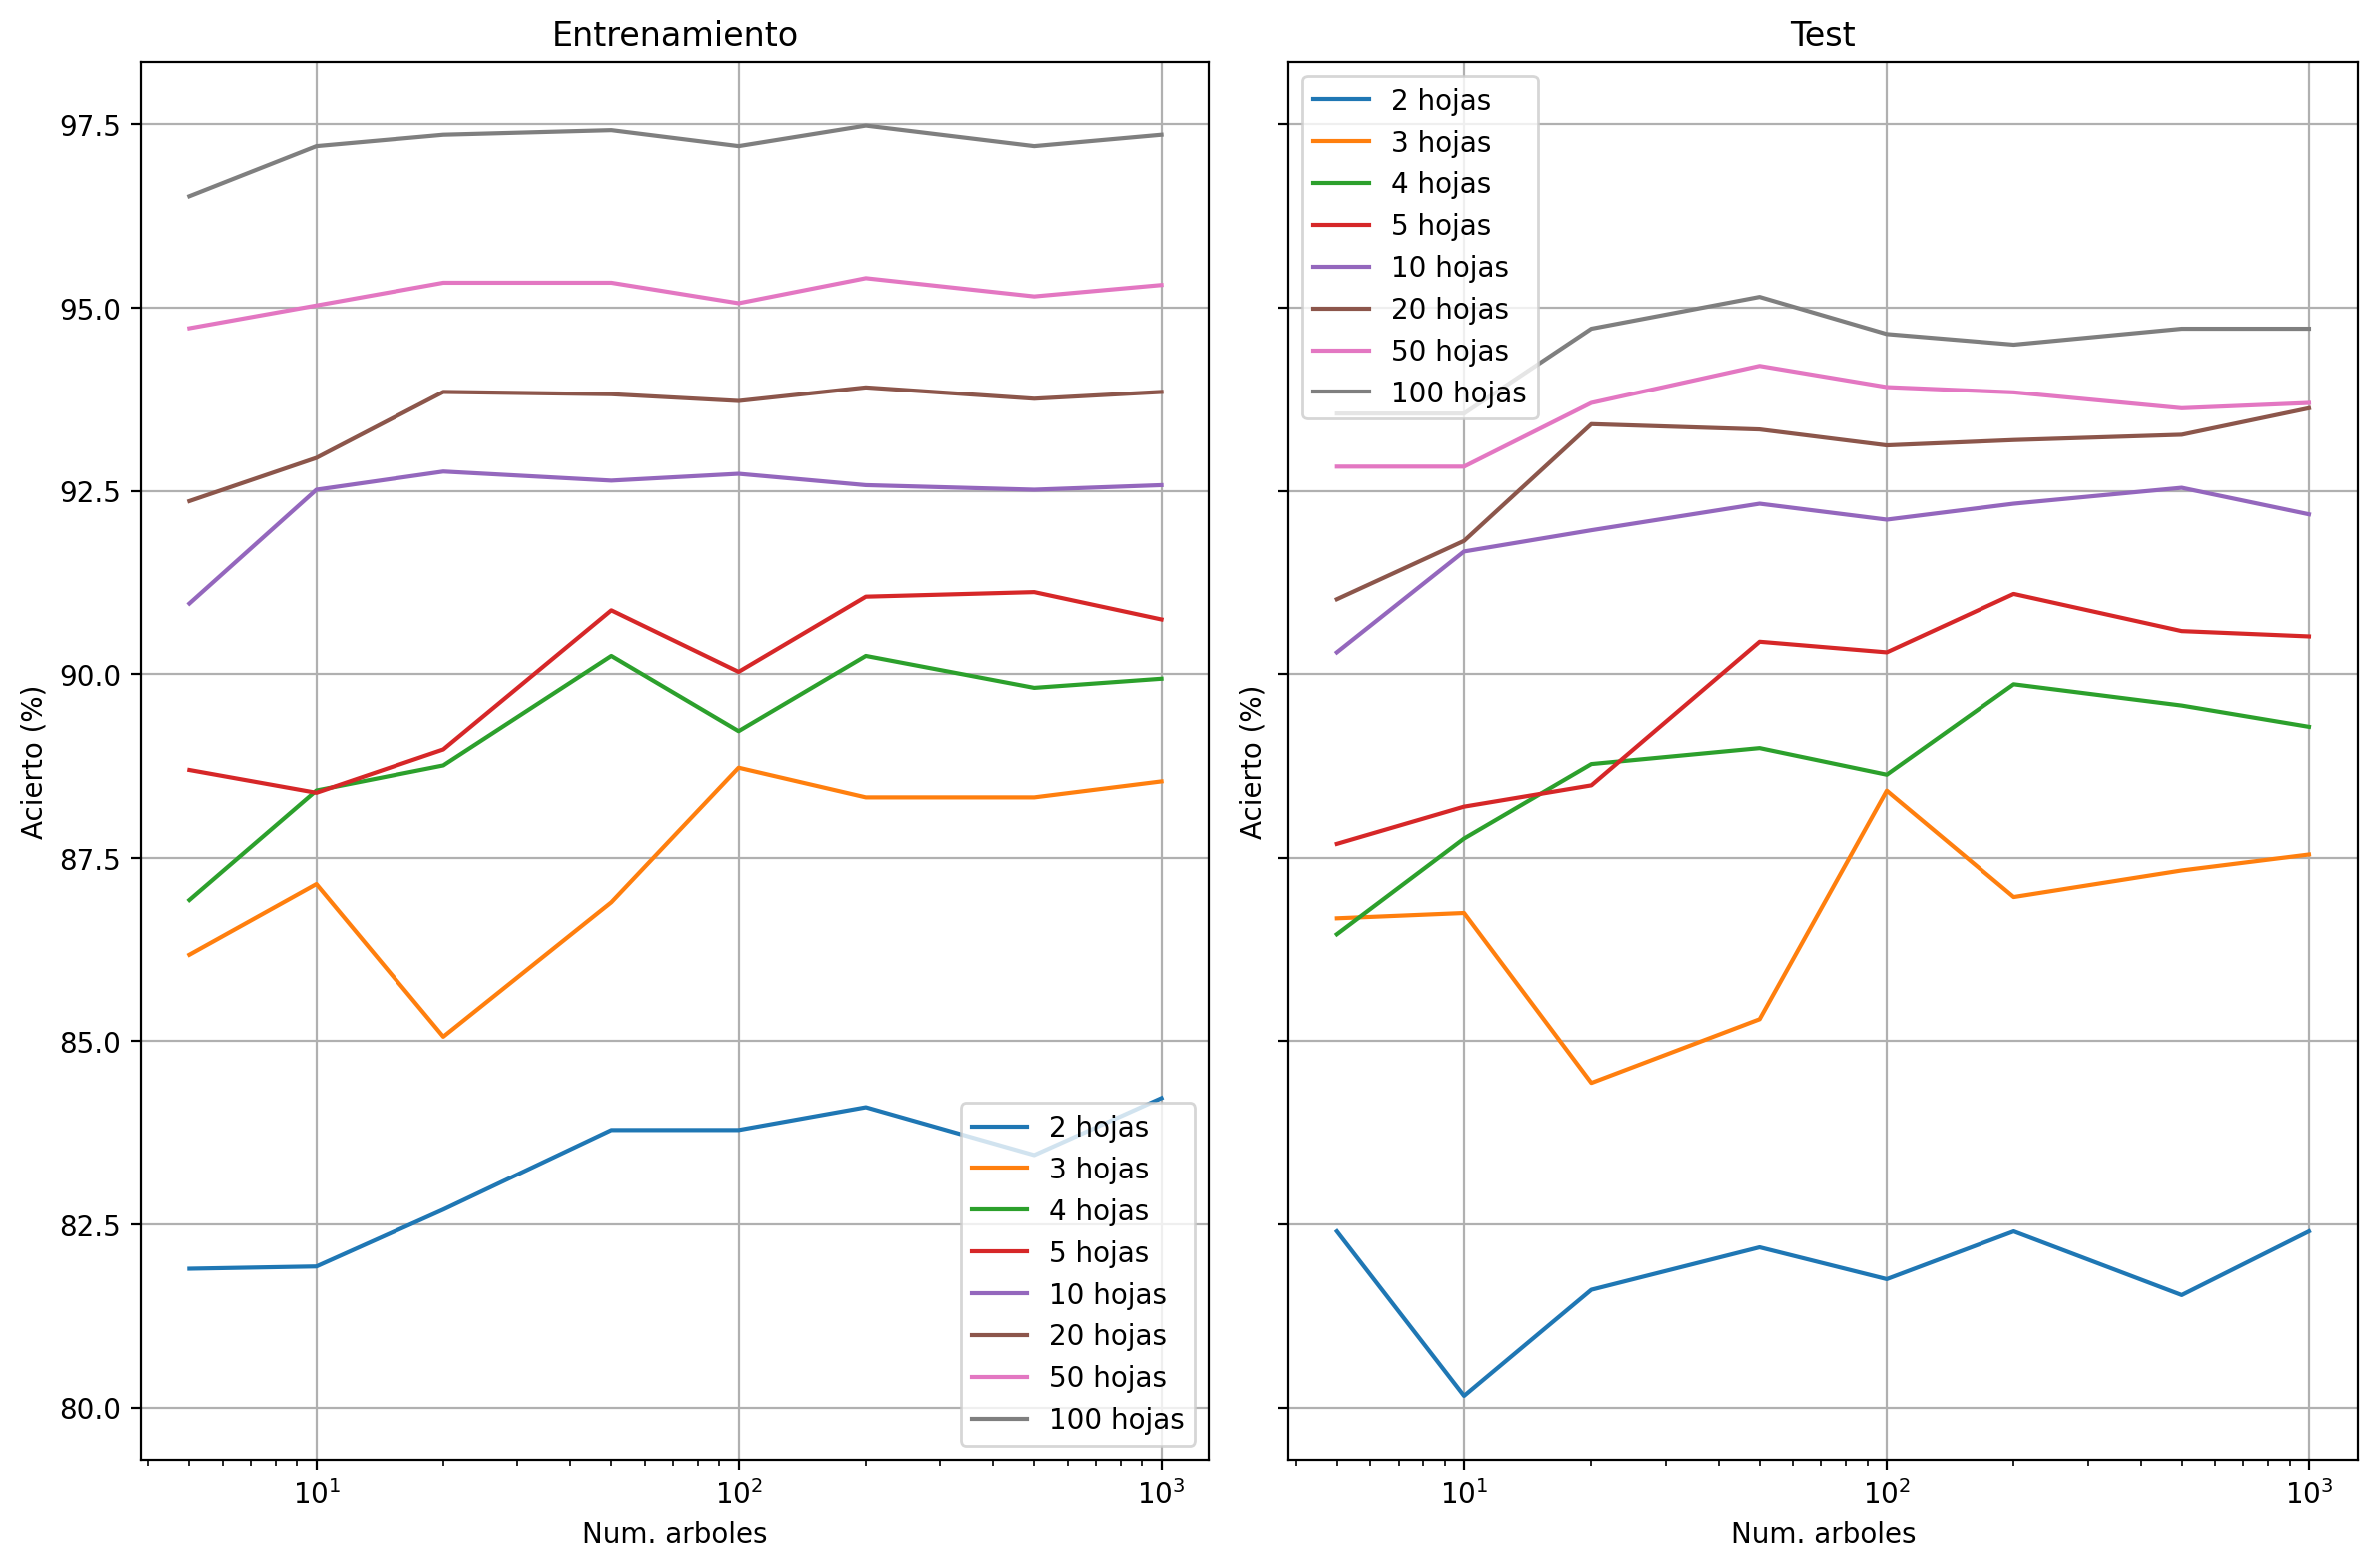

In [ ]:
ff,aa = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,8))
best_test = 0
best_num_arboles = -1
best_num_hojas = -1
for kk, hh in enumerate(v_hojas):
    dt_entr = np.empty(len(v_arboles))
    dt_test = np.empty(len(v_arboles))
    for ih,B in enumerate(v_arboles):
        RF = RandomForestClassifier(max_leaf_nodes=hh,
                       n_estimators=B)
        RF.fit(x_train, y_train)
        dt_entr[ih] = 100.*RF.score(x_train, y_train)
        dt_test[ih] = 100.*RF.score(x_test, y_test)
    if np.max(dt_test) > best_test:
      best_test = np.max(dt_test)
      best_num_arboles = B
      best_num_hojas = hh
    aa[0].plot(v_arboles, dt_entr, label='{0:d} hojas'.format(hh))
    aa[1].plot(v_arboles, dt_test, label='{0:d} hojas'.format(hh))
    aa[0].set_title('Entrenamiento')
    aa[1].set_title('Test')
for jj in [0,1]:
  aa[jj].set_xlabel('Num. arboles')
  aa[jj].set_xscale('log')
  aa[jj].legend()
  aa[jj].set_ylabel('Acierto (%)')
  aa[jj].grid()

ff.tight_layout()

ff.show()
print("La mejor configuración en test es {0:d} árboles de {1:d} hojas, acierto del {2:.2f}%".format(best_num_arboles, best_num_hojas, best_test))
acierto_spam_rf = best_test

Podemos observar cómo es más crítico el valor del número de hojas que el del número de árboles a la hora de determinar el éxito del modelo

# Resumen de los mejores métodos

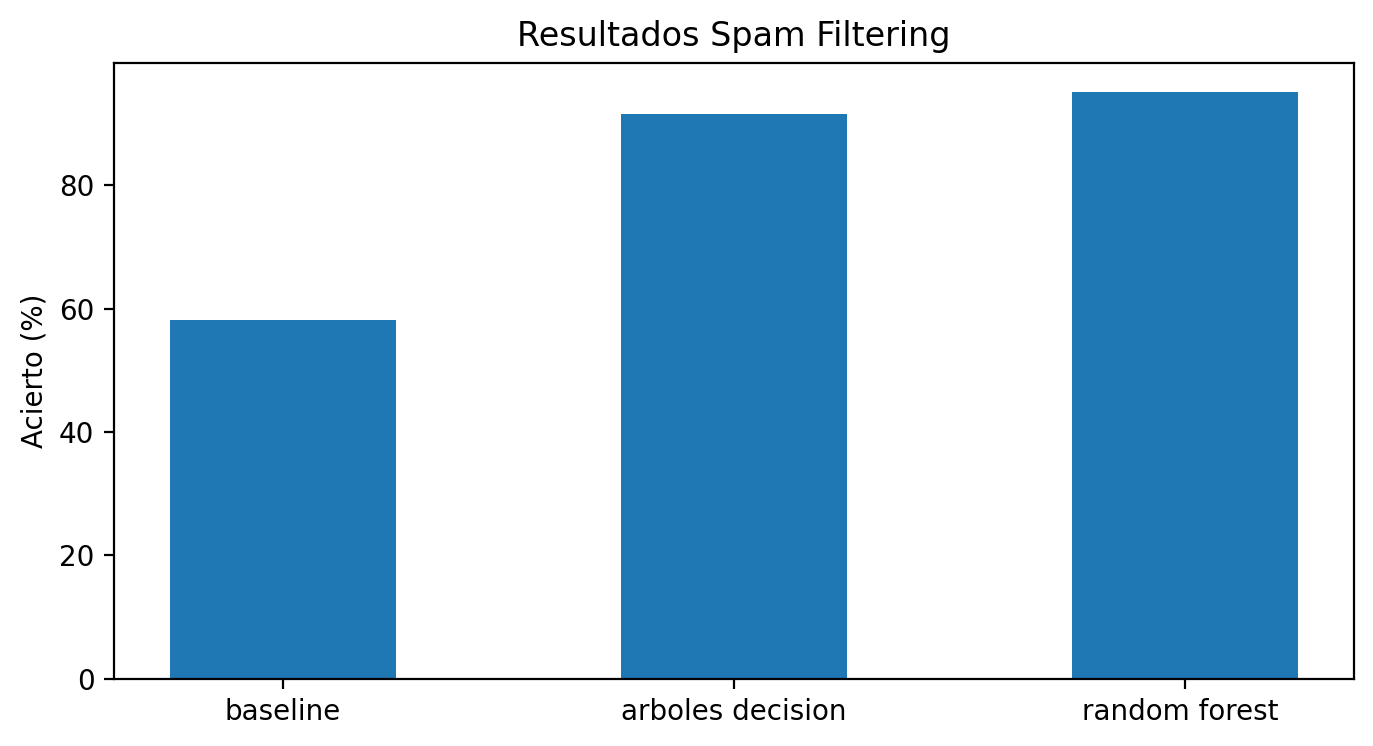

In [ ]:
metodos_spam = ['baseline','arboles decision','random forest ']
resultados_spam = [baseline_spam*100., acierto_spam_dt,acierto_spam_rf]
fx, ax = plt.subplots(1,1, figsize=(8,4))
_ = ax.bar(range(len(metodos_spam)),
       width=0.5,
       height=resultados_spam,
       tick_label=metodos_spam)
ax.set_ylabel('Acierto (%)')
_=ax.set_title('Resultados Spam Filtering')

## Puntos para discutir la idoneidad de las soluciones
- Precisión
- Explicabilidad de los resultados
- Capacidad de generalización
- Mantenimiento del modelo
- Tiempo de entrenamiento y de test
